In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
df = pd.read_csv('C:/Users/saide/Desktop/study/python_upskill/ml_algorithms/house_price.csv')

In [3]:
df

,Square_Footage,Num_Bedrooms,Num_Bathrooms,Year_Built,Lot_Size,Garage_Size,Neighborhood_Quality,House_Price
0,1360,2,1,1981,0.599637,0,5,2.623829e+05
1,4272,3,3,2016,4.753014,1,6,9.852609e+05
2,3592,1,2,2016,3.634823,0,9,7.779774e+05
3,966,1,2,1977,2.730667,1,8,2.296989e+05
4,4926,2,1,1993,4.699073,0,8,1.041741e+06
...,...,...,...,...,...,...,...,...
995,3261,4,1,1978,2.165110,2,10,7.014940e+05
996,3179,1,2,1999,2.977123,1,10,6.837232e+05
997,2606,4,2,1962,4.055067,0,2,5.720240e+05
998,4723,5,2,1950,1.930921,0,7,9.648653e+05


In [4]:
df = df.drop_duplicates()
df = df.fillna(df.median(numeric_only=True))
df = df.select_dtypes(include=[np.number])

In [5]:
target_col = "House_Price"  
X = df.drop(columns=[target_col])
y = df[target_col]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
class XGBNode:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

class XGBRegressionTreeScratch:
    def __init__(self, max_depth=3, min_child_weight=1.0, reg_lambda=1.0, gamma=0.0, random_state=None):
        self.max_depth = max_depth
        self.min_child_weight = float(min_child_weight)
        self.reg_lambda = float(reg_lambda)
        self.gamma = float(gamma)
        self.root = None
        self._rng = np.random.default_rng(random_state)

    def fit(self, X, g, h):
        X = np.array(X, dtype=float)
        g = np.array(g, dtype=float).reshape(-1)
        h = np.array(h, dtype=float).reshape(-1)
        self.root = self._build_tree(X, g, h, depth=0)
        return self

    def predict(self, X):
        X = np.array(X, dtype=float)
        return np.array([self._traverse(x, self.root) for x in X], dtype=float)

    def _leaf_weight(self, G, H):
        return -G / (H + self.reg_lambda + 1e-12)

    def _score(self, G, H):
        return 0.5 * (G ** 2) / (H + self.reg_lambda + 1e-12)

    def _build_tree(self, X, g, h, depth):
        n_samples, n_features = X.shape
        G = np.sum(g)
        H = np.sum(h)
        if depth >= self.max_depth or n_samples <= 1:
            return XGBNode(value=float(self._leaf_weight(G, H)))
        if H < self.min_child_weight:
            return XGBNode(value=float(self._leaf_weight(G, H)))
        best_gain = 0.0
        best_feature = None
        best_threshold = None
        parent_score = self._score(G, H)
        for feature in range(n_features):
            x_col = X[:, feature]
            order = np.argsort(x_col)
            x_sorted = x_col[order]
            g_sorted = g[order]
            h_sorted = h[order]
            G_prefix = np.cumsum(g_sorted)
            H_prefix = np.cumsum(h_sorted)
            for i in range(1, n_samples):
                if x_sorted[i] == x_sorted[i - 1]:
                    continue
                GL = G_prefix[i - 1]
                HL = H_prefix[i - 1]
                GR = G - GL
                HR = H - HL
                if HL < self.min_child_weight or HR < self.min_child_weight:
                    continue
                gain = (self._score(GL, HL) + self._score(GR, HR) - parent_score) - self.gamma
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = (x_sorted[i - 1] + x_sorted[i]) / 2.0
        if best_feature is None or best_gain <= 0:
            return XGBNode(value=float(self._leaf_weight(G, H)))
        left_mask = X[:, best_feature] <= best_threshold
        right_mask = ~left_mask
        left = self._build_tree(X[left_mask], g[left_mask], h[left_mask], depth + 1)
        right = self._build_tree(X[right_mask], g[right_mask], h[right_mask], depth + 1)
        return XGBNode(feature=best_feature, threshold=best_threshold, left=left, right=right)

    def _traverse(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature] <= node.threshold:
            return self._traverse(x, node.left)
        return self._traverse(x, node.right)


In [9]:
class XGBoostRegressorScratch:
    def __init__(
        self,
        n_estimators=200,
        learning_rate=0.1,
        max_depth=3,
        min_child_weight=1.0,
        reg_lambda=1.0,
        gamma=0.0,
        random_state=42
    ):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_child_weight = min_child_weight
        self.reg_lambda = reg_lambda
        self.gamma = gamma
        self.random_state = random_state
        self.base_score = None
        self.trees = []
        self.loss_history = []
        self._rng = np.random.default_rng(random_state)
    def fit(self, X, y):
        X = np.array(X, dtype=float)
        y = np.array(y, dtype=float).reshape(-1)
        self.base_score = float(np.mean(y))
        y_pred = np.full_like(y, self.base_score, dtype=float)
        self.trees = []
        self.loss_history = []
        for _ in range(self.n_estimators):
            g = y_pred - y      # d/dyhat (1/2)(y-yhat)^2 = (yhat - y)
            h = np.ones_like(y) # second derivative = 1
            tree = XGBRegressionTreeScratch(
                max_depth=self.max_depth,
                min_child_weight=self.min_child_weight,
                reg_lambda=self.reg_lambda,
                gamma=self.gamma,
                random_state=int(self._rng.integers(0, 1_000_000_000))
            )
            tree.fit(X, g, h)
            update = tree.predict(X)
            y_pred += self.learning_rate * update
            mse = np.mean((y - y_pred) ** 2)
            self.loss_history.append(mse)
            self.trees.append(tree)
        return self

    def predict(self, X):
        X = np.array(X, dtype=float)
        y_pred = np.full(X.shape[0], self.base_score, dtype=float)
        for tree in self.trees:
            y_pred += self.learning_rate * tree.predict(X)
        return y_pred


In [10]:
xgb = XGBoostRegressorScratch(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    min_child_weight=10.0,
    reg_lambda=1.0,
    gamma=0.0,
    random_state=42
)
xgb.fit(X_train.values, y_train.values)
y_pred_xgb = xgb.predict(X_test.values)


In [11]:
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost (Scratch) Metrics")
print("MSE :", mse_xgb)
print("RMSE:", rmse_xgb)
print("MAE :", mae_xgb)
print("R2  :", r2_xgb)

XGBoost (Scratch) Metrics
MSE : 204816622.99159828
RMSE: 14311.415827639077
MAE : 11711.59240595562
R2  : 0.9968225216479147


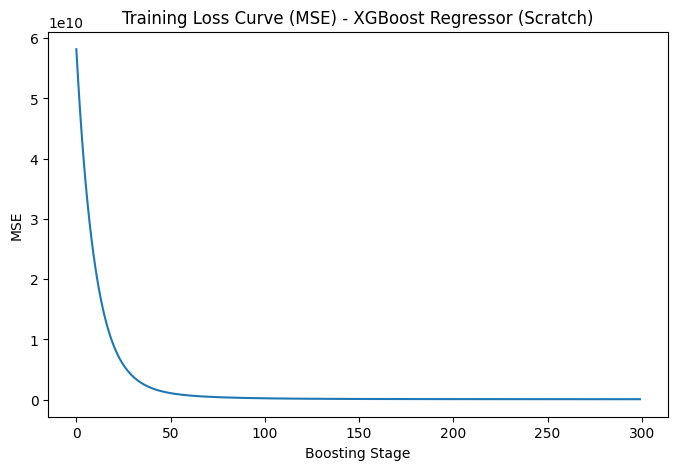

In [12]:
# Loss curve
plt.figure(figsize=(8, 5))
plt.plot(xgb.loss_history)
plt.title("Training Loss Curve (MSE) - XGBoost Regressor (Scratch)")
plt.xlabel("Boosting Stage")
plt.ylabel("MSE")
plt.show()

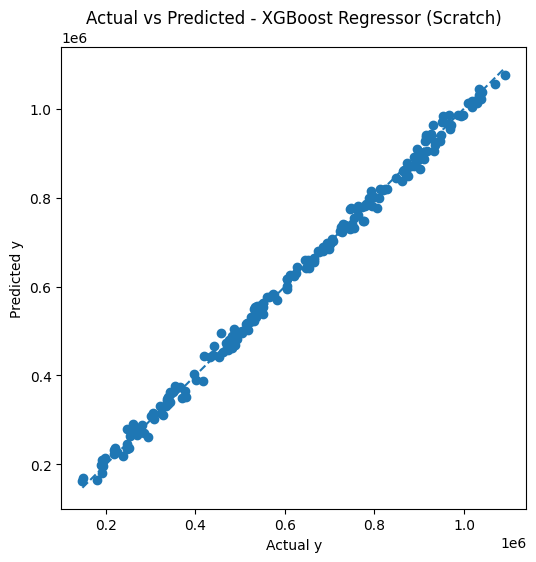

In [13]:
# Actual vs Predicted
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_xgb)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle='--')
plt.title("Actual vs Predicted - XGBoost Regressor (Scratch)")
plt.xlabel("Actual y")
plt.ylabel("Predicted y")
plt.show()

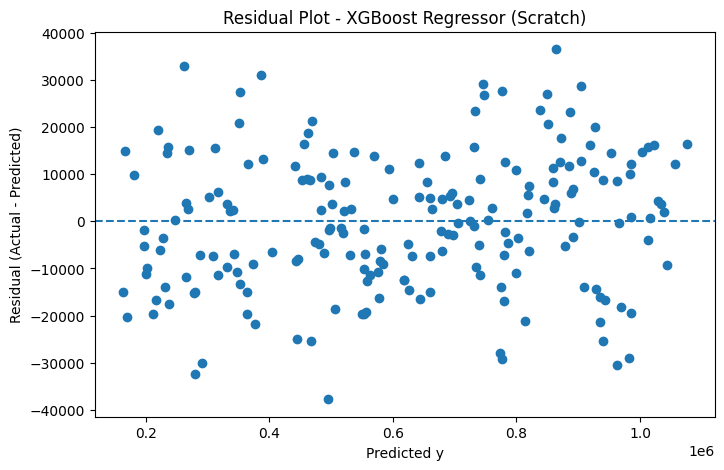

In [14]:
# Residual plot
residuals_xgb = y_test.values - y_pred_xgb
plt.figure(figsize=(8, 5))
plt.scatter(y_pred_xgb, residuals_xgb)
plt.axhline(0, linestyle='--')
plt.title("Residual Plot - XGBoost Regressor (Scratch)")
plt.xlabel("Predicted y")
plt.ylabel("Residual (Actual - Predicted)")
plt.show()

In [15]:
xgb_results = pd.DataFrame([{
    "Model": "XGBoost Regressor (Scratch)",
    "MSE": mse_xgb,
    "RMSE": rmse_xgb,
    "MAE": mae_xgb,
    "R2": r2_xgb,
    "Estimators": 300,
    "Learning Rate": 0.05,
    "Max Depth": 3,
    "min_child_weight": 10.0,
    "lambda": 1.0,
    "gamma": 0.0
}])
xgb_results

,Model,MSE,RMSE,MAE,R2,Estimators,Learning Rate,Max Depth,min_child_weight,lambda,gamma
0,XGBoost Regressor (Scratch),2.048166e+08,14311.415828,11711.592406,0.996823,300,0.05,3,10.0,1.0,0.0
